In [1]:
import time

import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import wikipediaapi

In [2]:
wiki = wikipediaapi.Wikipedia(user_agent="waynestalk/1.0", language="en")
page = wiki.page("Oolong")
corpus = page.text

nltk.download("punkt")
sentences = nltk.sent_tokenize(corpus)
tokenized_corpus = [[word.lower() for word in nltk.word_tokenize(sentence) if word.isalpha()] for sentence in sentences]
tokenized_corpus[:5]

[nltk_data] Downloading package punkt to /Users/wayne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['oolong',
  'uk',
  'us',
  'simplified',
  'chinese',
  '乌龙茶',
  'traditional',
  'chinese',
  '烏龍茶',
  'pinyin',
  'wūlóngchá',
  'tê',
  'black',
  'dragon',
  'tea',
  'is',
  'a',
  'traditional',
  'chinese',
  'tea',
  'camellia',
  'sinensis',
  'produced',
  'through',
  'a',
  'process',
  'that',
  'includes',
  'withering',
  'the',
  'leaves',
  'under',
  'strong',
  'sun',
  'and',
  'allowing',
  'some',
  'oxidation',
  'to',
  'occur',
  'before',
  'curling',
  'and',
  'twisting'],
 ['most',
  'oolong',
  'teas',
  'especially',
  'those',
  'of',
  'fine',
  'quality',
  'involve',
  'unique',
  'tea',
  'plant',
  'cultivars',
  'that',
  'are',
  'exclusively',
  'used',
  'for',
  'particular',
  'varieties'],
 ['the',
  'degree',
  'of',
  'oxidation',
  'which',
  'is',
  'controlled',
  'by',
  'the',
  'length',
  'of',
  'time',
  'between',
  'picking',
  'and',
  'final',
  'drying',
  'can',
  'range',
  'from',
  'to',
  'depending',
  'on',
  'the',


In [3]:
vocab = set([word for sentence in tokenized_corpus for word in sentence])
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}
len(vocab)


580

In [4]:
window_size = 2
training_pairs = []

for sentence in tokenized_corpus:
    for i, target_word in enumerate(sentence):
        context_indices = (list(range(max(i - window_size, 0), i)) +
                           list(range(i + 1, min(i + window_size, len(sentence)))))
        for context_index in context_indices:
            training_pairs.append((target_word, sentence[context_index]))
training_pairs[:5]

[('oolong', 'uk'),
 ('uk', 'oolong'),
 ('uk', 'us'),
 ('us', 'oolong'),
 ('us', 'uk')]

In [5]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, word):
        vector = self.embedding(word)
        return self.linear(vector)

In [6]:
model = SkipGram(len(vocab), 1000)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 500

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0
    for target, context in training_pairs:
        target_tensor = torch.tensor([word_to_index[target]], dtype=torch.long)
        context_tensor = torch.tensor([word_to_index[context]], dtype=torch.long)
        output = model(target_tensor)
        loss = loss_function(output, context_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss}")

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch: 0, Loss: 39987.801153186476
Epoch: 99, Loss: 30384.4197357425
Epoch: 199, Loss: 26906.040692283364
Epoch: 299, Loss: 24592.846442646056
Epoch: 399, Loss: 22867.418499057472
Epoch: 499, Loss: 21502.15208007075
Training time: 1074.5490338802338 seconds


In [7]:
word = "oolong"
word_index_tensor = torch.tensor(word_to_index[word], dtype=torch.long)
embedding_vector = model.embedding(word_index_tensor).detach().numpy()
print(f"Embedding {embedding_vector.shape} for '{word}': {embedding_vector}")

Embedding (1000,) for 'oolong': [ 1.17656931e-01  1.15448080e-01  8.99124593e-02 -9.01386887e-02
  3.51919174e-01  4.21235077e-02 -9.51160863e-02  2.25634083e-01
  6.10320130e-03  1.33073986e-01  1.12412777e-02  7.38745034e-02
  3.19788665e-01 -3.87759730e-02  3.85251082e-02  5.22653535e-02
  1.29554361e-01 -2.16154322e-01  8.10467079e-02 -3.17479730e-01
 -5.26730530e-02  2.91658729e-01 -8.35999325e-02 -4.11323279e-01
 -3.81739717e-03 -1.71413988e-01  2.71810830e-01  1.22611215e-02
 -3.47485878e-02 -3.66397649e-02  3.45212370e-02 -3.91356722e-02
  3.12000848e-02 -2.66769499e-01  6.94936365e-02  2.87182063e-01
 -5.38775809e-02 -2.66620666e-01  1.38358325e-01 -1.55875534e-01
 -2.05117360e-01  1.09150428e-02 -2.68343002e-01  9.58991945e-02
 -1.29106253e-01 -1.15711145e-01 -1.04367897e-01  2.01725021e-01
  1.48055881e-01  8.62071365e-02 -3.56744342e-02 -1.78049192e-01
  1.31836742e-01  4.39013056e-02  9.29054916e-02 -3.85259479e-01
  9.33105201e-02 -3.95244136e-02 -7.60864615e-02  2.645603

In [8]:
sentence1 = "tea is popular in taiwan".split()
sentence2 = "oolong is famous in taiwan".split()
sentence1_embeddings = [model.embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence1]
sentence2_embeddings = [model.embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence2]
vector1 = torch.stack(sentence1_embeddings).mean(dim=0)
vector2 = torch.stack(sentence2_embeddings).mean(dim=0)
cosine_sim = nn.CosineSimilarity(dim=0)
similarity = cosine_sim(vector1, vector2).item()
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Similarity between sentences: {similarity}")

Sentence 1: ['tea', 'is', 'popular', 'in', 'taiwan']
Sentence 2: ['oolong', 'is', 'famous', 'in', 'taiwan']
Similarity between sentences: 0.350554883480072


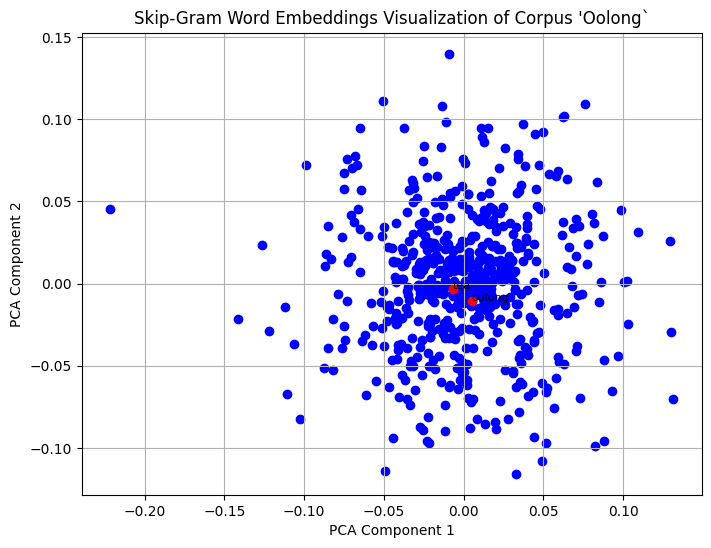

In [9]:
word_embeddings_tensor = model.embedding.weight.detach()
U, S, V = torch.pca_lowrank(word_embeddings_tensor, q=2)
reduced_embeddings = U.numpy()

plt.figure(figsize=(8, 6))

for word, index in word_to_index.items():
    x, y = reduced_embeddings[index]
    plt.scatter(x, y, marker='o', color='blue')

tea_index = word_to_index['tea']
x, y = reduced_embeddings[tea_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'tea', fontsize=8)

oolong_index = word_to_index['oolong']
x, y = reduced_embeddings[oolong_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'oolong', fontsize=8)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Skip-Gram Word Embeddings Visualization of Corpus 'Oolong`")
plt.grid(True)
plt.show()